In [58]:
import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

Populating the interactive namespace from numpy and matplotlib


In [149]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:55]].min()

def scale(x):
    #scaler = MinMaxScaler()
    scaler = StandardScaler()
    scaler.fit(x)# + [0]*52)
    return scaler, scaler.transform(x)

In [5]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh)
            neigh.fit(x2, y)
            
            groups = list(df.index.get_level_values(0))
            
            cv=GroupKFold(n_splits=3).split(x2, y, groups)
            score = cross_val_score(neigh, x2, y, cv=cv).mean() # cv=cv
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [175]:
out_dir = '../../papi_output/'
paths = [out_dir + p for p in ['o12l.csv', 'o13l.csv', 'o14l.csv']]

dfs = [pd.read_csv(path, error_bad_lines=False) for path in paths]
df = pd.concat(dfs)
df = aggregate(df)

df = df.loc[df['time'] > 1]

for col in df.columns[:52]:
    df[col] = df[col].apply(lambda q: np.log(q) if q>0 else 0)

cols = sorted(list(df.columns.values))
df = df[cols]

x = df.iloc[:,:52].as_matrix()
scaler, x = scale(x)
y = df.iloc[:,52].as_matrix()

df.shape

/usr/lib/python3/dist-packages/ipykernel_launcher.py:16: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  app.launch_new_instance()
/usr/lib/python3/dist-packages/ipykernel_launcher.py:18: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.


(2597, 53)

In [176]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 15, 3), range(6, 20, 4))

2 	 6 	 0.66
2 	 10 	 0.7
2 	 14 	 0.7
2 	 18 	 0.71
5 	 6 	 0.52
5 	 10 	 0.5
5 	 14 	 0.5
5 	 18 	 0.48
8 	 6 	 0.7
8 	 10 	 0.64
8 	 14 	 0.61
8 	 18 	 0.56
11 	 6 	 0.73
11 	 10 	 0.64
11 	 14 	 0.59
11 	 18 	 0.54
14 	 6 	 0.74
14 	 10 	 0.63
14 	 14 	 0.56
14 	 18 	 0.52
--------------
PCA:	 14
kNN:	 6
Score:	 0.7394798991389785


In [179]:
pca = PCA(n_components=2)
pca.fit(x)
x2 = pca.transform(x)
pca.explained_variance_ratio_.sum()

0.6084015610158067

In [139]:
svr = SVR(kernel='poly', C=1, epsilon=.1)
svr.fit(x2, y)
clf = svr

In [189]:
neigh = KNeighborsRegressor(n_neighbors=1)
neigh.fit(x2, y) 
clf = neigh

In [38]:
regr = RandomForestRegressor(max_depth=2, random_state=0)
regr.fit(x2, y)
clf = regr

In [147]:
groups = list(df.index.get_level_values(0))
n_groups = int(len(set(groups)) / 3)

cv=GroupKFold(n_splits=3).split(x2, y, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]

scores = cross_val_score(clf, x2, y, cv=cvres)

print('\n'.join([str(round(s, 2))+'\t'+g for g, s in zip(group_names, scores)]))
scores.mean()

0.3	lore_1f71e097-a54f-4e21-aa18-60c01ec75f66_1024
0.87	lore_1e5201b1-b9b4-442e-960e-94b11bbc01bc_143
0.76	lore_1e5201b1-b9b4-442e-960e-94b11bbc01bc_248


0.6427987998307162

In [187]:
def graph(clf, pca, x2):
    if pca.n_components != 2:
        print('PCA must be 2D')

    norm = matplotlib.colors.LogNorm(vmin=y.min(), vmax=y.max())
    fig, ax = plt.subplots()
    
    plt.title('Prediction after dimensionality reduction')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    
    x0 = x2[:,0]
    x1 = x2[:,1]

    # grid
    xmin = min(x0)
    xmax = max(x0)
    xstep = (xmax-xmin)/99.1

    ymin = min(x1)
    ymax = max(x1)
    ystep = (ymax-ymin)/99.1

    xrange = np.arange(xmin, xmax, xstep)
    yrange = np.arange(ymin, ymax, ystep)
    xx, yy = np.meshgrid(xrange, yrange)

    xrange_grid = np.arange(xmin-xstep/2, xmax+xstep/2, xstep)
    yrange_grid = np.arange(ymin-ystep/2, ymax+ystep/2, ystep)
    xx_grid, yy_grid = np.meshgrid(xrange_grid, yrange_grid)

    ypred = clf.predict(list(zip(xx.ravel(), yy.ravel())))
    ypred = [q if q>0 else y.min() for q in ypred]
    ypred = np.array(ypred).reshape(len(yrange_grid)-1, len(xrange_grid)-1)

    pcm = ax.pcolor(xx_grid, yy_grid, ypred, norm=norm)

    cbar = fig.colorbar(pcm, ax=ax, extend='max')
    cbar.set_label('Execution time (log scale)', rotation=270, va='top')

    # scatter
    ax.scatter(x2[:,0], x2[:,1], c=y, norm=norm, edgecolors='black', s=60)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)

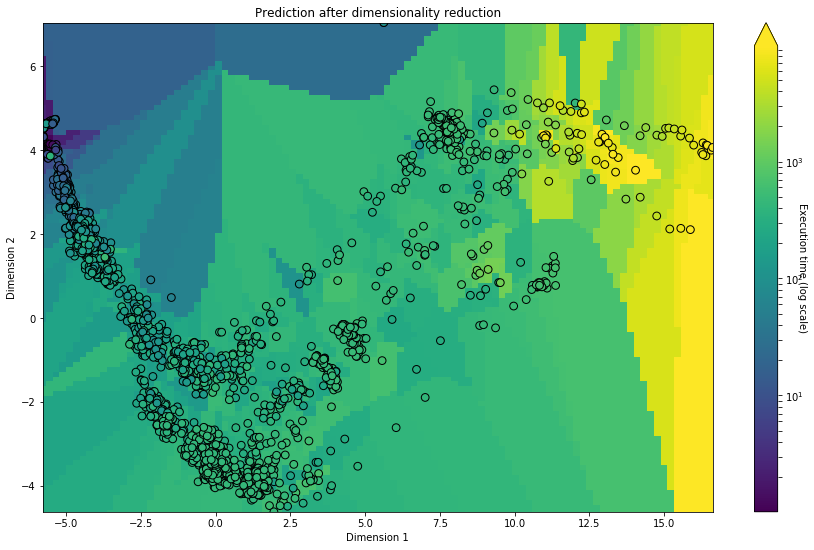

In [190]:
graph(clf, pca, x2)

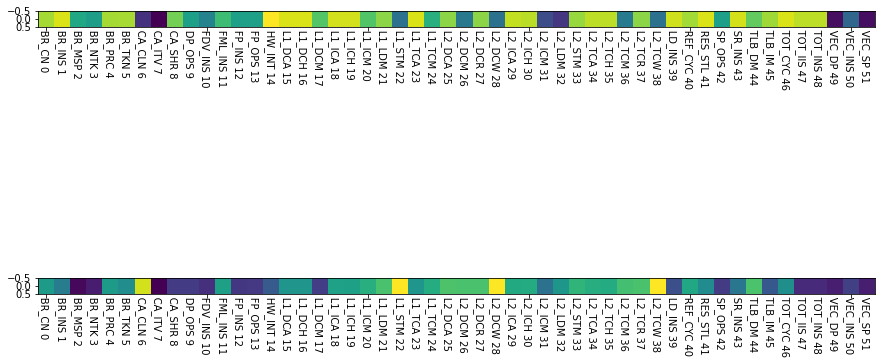

In [182]:
# just to visualize which of 52 PAPI output events are most significant (marked in yellow)

lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    for j, txt in enumerate(lab):
        ax.annotate('      '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    pcas = [abs(q) for q in pca.components_[i:i+1]]
    ax.imshow(pcas)
    ax.set_xticklabels([])
plt.show()

In [183]:
def graph_clusters(pca, x2):
    if pca.n_components != 2:
        print('PCA must be 2D')
        
    db = DBSCAN(eps=0.3, min_samples=10)
    groups = list(df.index.get_level_values(0))
    labels = db.fit_predict(x2)
    
    a = np.array([[l, g] for l, g in zip(labels, groups)])
    algs = unique(a[:,1])
    clusters = unique(a[:,0])
    clusters_algs = array( [ list(a[a[:,1]==i,0]) for i in algs] )
    
    print(len(algs))
    
    #for ca, alg in zip(clusters_algs, algs):
    #    q = [collections.Counter(ca)[str(k)] for k in clusters]
    #    print('kernel', alg.split('_')[-1], '\t', '\t'.join([str(qq) for qq in q]), '\t| ', max(q)/sum(q))
    
    fig, ax = plt.subplots()
    
    plt.title('Clusters')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')

    # scatter
    ax.scatter(x2[:,0], x2[:,1], c=labels, cmap='tab10', s=60)

92


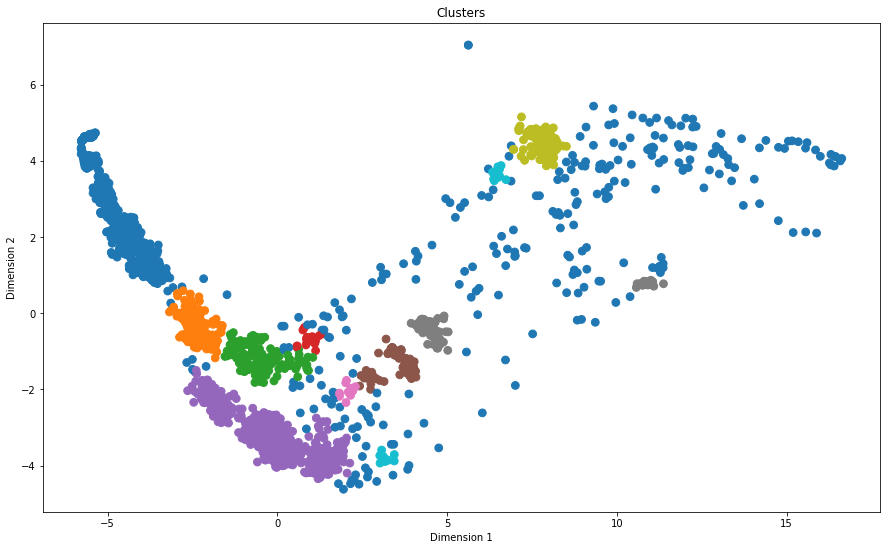

In [184]:
graph_clusters(pca, x2)